# Imports

In [1]:
from climada.hazard import Centroids, TCTracks, TropCyclone
from climada.util.api_client import Client

ERROR 1: PROJ: proj_create_from_database: Open of /home/sjuhel/miniforge3/envs/climada_env_TC/share/proj failed
/home/sjuhel/miniforge3/envs/climada_env_TC/lib/python3.11/site-packages/dask/dataframe/_pyarrow_compat.py:17: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 12.0.1. Please consider upgrading.
  warnings.warn(


In [2]:
from climada import _version

In [3]:
_version.__version__

'5.0.1-dev'

# Scratch

## Read tracks

In [21]:
#  Possible values are 'NA'   (North Atlantic), 'SA' (South Atlantic), 'EP' (Eastern North Pacific, which includes the Central Pacific region), 'WP' (Western North Pacific), 'SP' (South Pacific),  'SI' (South Indian), 'NI' (North Indian).

for basin in ["NA", "SA", "EP", "WP", "SP", "SI", "NI"]:
    tracks = TCTracks.from_ibtracs_netcdf(
        year_range=(1980, 2023),
        genesis_basin=basin,
    )
    print(basin, ": ", len(tracks.data))

2024-08-13 10:16:32,210 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/sjuhel/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-08-13 10:16:54,353 - climada.hazard.tc_tracks - WARNING - 57 storm events are discarded because no valid wind/pressure values have been found: 1980199N31284, 1980200N25270, 1980204N23287, 1980226N15339, 1980238N16328, ...
NA :  651
2024-08-13 10:16:58,156 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/sjuhel/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrA

In [32]:
start_years = list(range(1980, 2024, 1))
periods = [(str(start), str(min(start, 2023))) for start in start_years]

for start, end in periods[0]:
    tracks = TCTracks.from_ibtracs_netcdf(
        year_range=(int(start), int(end)),
        genesis_basin="WP",
    )
    print(start, "-", end, ": ", len(tracks.data))

ValueError: too many values to unpack (expected 2)

In [34]:
tracks = TCTracks.from_ibtracs_netcdf(
        year_range=(int(start), int(end)),
        genesis_basin="WP",
    )

2024-08-13 11:14:15,801 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/sjuhel/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.
2024-08-13 11:14:17,444 - climada.hazard.tc_tracks - WARNING - 3 storm events are discarded because no valid wind/pressure values have been found: 1988210N22137, 1988264N16111, 1988306N15130.


<GeoAxes: >

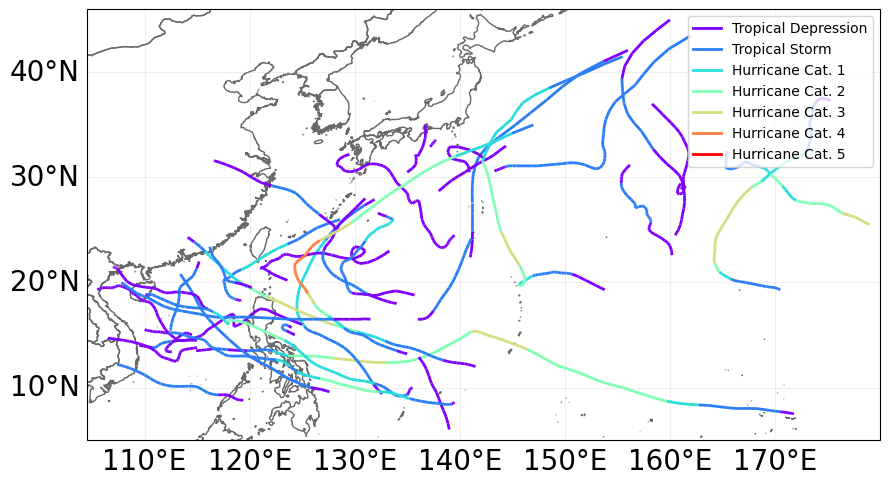

In [35]:
tracks.plot()

In [37]:
len(tracks.data)


39

In [38]:
tracks.equal_timestep(0.5)

In [39]:
tracks.calc_perturbed_trajectories()

In [40]:
len(tracks.data)

390

## Create centroids (we try to match litpop grid as best as possible)

In [35]:
def create_litpop_matching_centroids(res=0.041666659999975764):
    centroids_land = Centroids.from_pnt_bounds(
        (-180 + res / 2, -90 + res / 2, 180 - res / 2, 90), res
    )
    centroids_land.set_on_land()

    centroids_water = Centroids.from_pnt_bounds((-180, -90, 180, 90), 0.5)
    centroids_water.set_on_land()
    cent = centroids_land.select(sel_cen=centroids_land.on_land).union(
        centroids_water.select(sel_cen=~centroids_water.on_land)
    )
    return cent

In [36]:
cent = create_litpop_matching_centroids()

In [37]:
cent_tracks = cent.select(extent=tracks.get_extent(5))

<GeoAxes: >

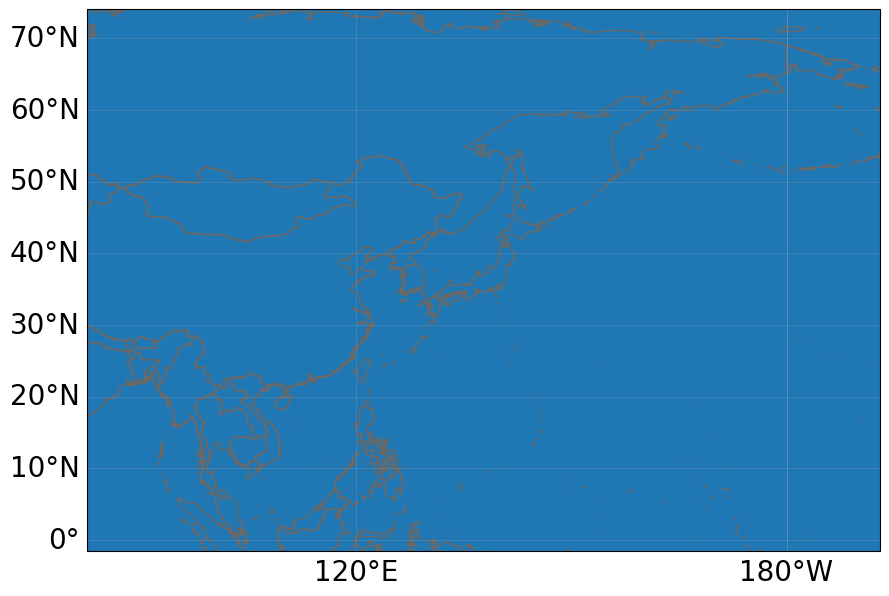

In [38]:
cent_tracks.plot()

## Compute TC impact

In [ ]:
tc = TropCyclone.from_tracks(tracks, cent)

ValueError: need at least one array to concatenate

<GeoAxes: title={'center': 'TC max intensity at each point'}>

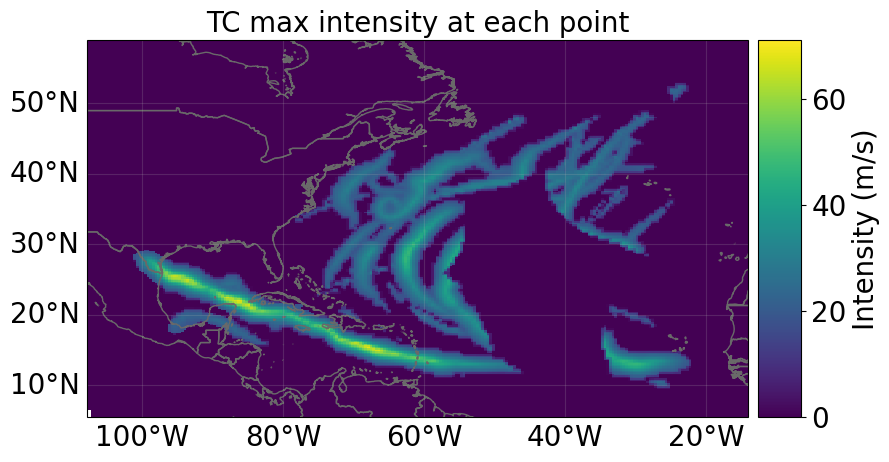

In [18]:
tc.plot_intensity(0)

<GeoAxes: >

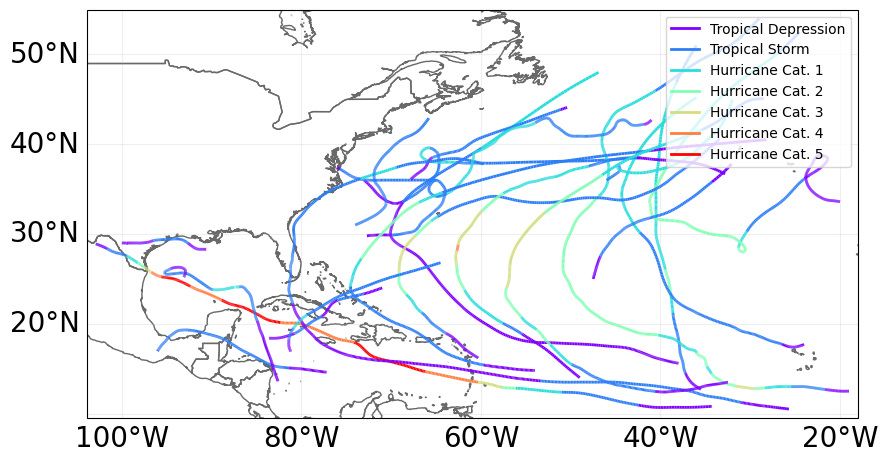

In [19]:
tracks.plot()

## Synth tracks

In [4]:
tr = TCTracks.from_ibtracs_netcdf(provider="usa", storm_id="2017242N16333")  # IRMA 2017

2024-08-09 15:23:57,163 - climada.hazard.tc_tracks - WARNING - The cached IBTrACS data set dates from 2023-06-07 23:07:38 (older than 180 days). Very likely, a more recent version is available. Consider manually removing the file /home/sjuhel/climada/data/IBTrACS.ALL.v04r00.nc and re-running this function, which will download the most recent version of the IBTrACS data set from the official URL.


/home/sjuhel/Repos/climada_python/climada/hazard/tc_tracks.py:617: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  if ibtracs_ds.dims['storm'] == 0:


<GeoAxes: >

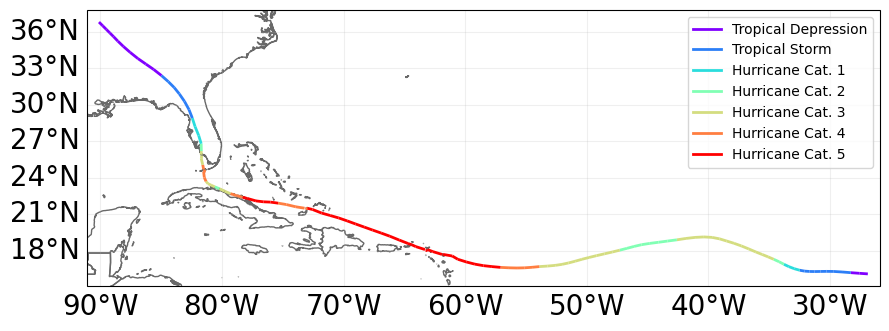

In [5]:
tr.plot()

In [6]:
tr.equal_timestep()

/home/sjuhel/Repos/climada_python/climada/hazard/tc_tracks.py:1511: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "_one_interp_data" failed type inference due to: non-precise type pyobject
During: typing of argument at /home/sjuhel/Repos/climada_python/climada/hazard/tc_tracks.py (1545)

File "../Repos/climada_python/climada/hazard/tc_tracks.py", line 1545:
    def _one_interp_data(track, time_step_h, land_geom=None):
        <source elided>

            time_step = pd.tseries.frequencies.to_offset(pd.Timedelta(hours=time_step_h)).freqstr
            ^

  @staticmethod
<string>:6: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.


In [7]:
tr.calc_perturbed_trajectories()

<GeoAxes: >

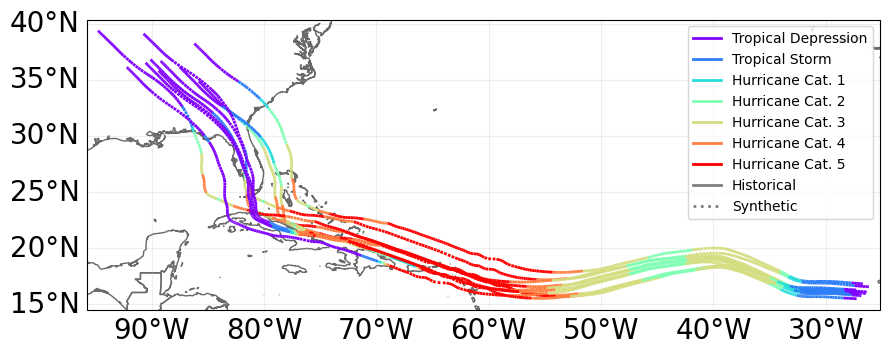

In [9]:
tr.plot()